In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd
from tabulate import tabulate
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Path to the dataset
ratings_path = '/content/drive/My Drive/MatrixCompletion/ratings.csv'
movies_path = '/content/drive/My Drive/MatrixCompletion/movies.csv'
tags_path = '/content/drive/My Drive/MatrixCompletion/tags.csv'
links_path = '/content/drive/My Drive/MatrixCompletion/links.csv'

# Load the dataset
ratings = pd.read_csv(ratings_path)
movies = pd.read_csv(movies_path)
tags = pd.read_csv(tags_path)
links = pd.read_csv(links_path)


In [45]:
links.head(10)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
5,6,113277,949.0
6,7,114319,11860.0
7,8,112302,45325.0
8,9,114576,9091.0
9,10,113189,710.0


In [46]:
ratings_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

In [47]:
print(ratings_matrix.shape)

(610, 9724)


In [48]:
non_nan_count = ratings_matrix.count().sum()
print("Number of non-NaN entries:", non_nan_count)


Number of non-NaN entries: 100836


In [49]:
import numpy as np

non_nan_count = np.sum(np.isnan(ratings_matrix.values))
print("Number of non-NaN entries:", non_nan_count)


Number of non-NaN entries: 5830804


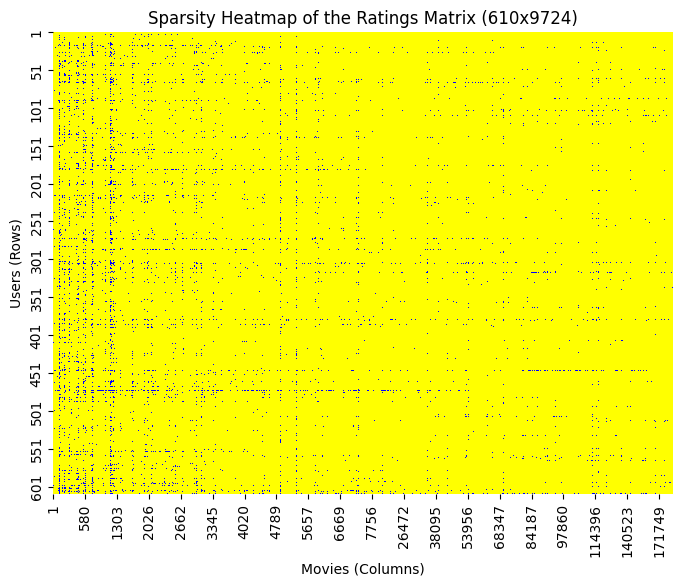

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap

# Custom colormap to highlight missing values (NaN) distinctly
colors = ['blue', 'yellow']  # Yellow for missing, Blue for present
custom_cmap = ListedColormap(colors)

# Generate the sparsity heatmap for the full matrix
plt.figure(figsize=(8, 6))  # Adjust figure size for clarity
sns.heatmap(ratings_matrix.isna(),
            cbar=False,
            cmap=custom_cmap,  # Apply custom colormap
            xticklabels=500,  # Show every 500th movie on the x-axis
            yticklabels=50,   # Show every 50th user on the y-axis
            linewidths=0,
            linecolor='white')

plt.title("Sparsity Heatmap of the Ratings Matrix (610x9724)")
plt.xlabel("Movies (Columns)")
plt.ylabel("Users (Rows)")
plt.show()


Keeping the NaN values without converting them to 0 because a user can rate the movie as 0, which can cause issues.

In [51]:
print(tabulate(ratings_matrix.head(10), headers='keys', tablefmt='pretty'))

+--------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+

For any matrix with ratings, we need some ratings for a user, otherwise any robust algorithm will not be of use.

Mean, median, mode imputation does not capture any relation between users and movies. It considers either movies or users to fill the missing values.

Neighborhood based collaborative filtering like user-based fills the missing values based on almost similar users.

In this next tab, I will run user-user based collaborative filtering.

In [52]:
# Replace NaN with 0 for similarity calculation
ratings_filled = np.nan_to_num(ratings_matrix)

# Compute User-User Cosine Similarity
user_similarity = cosine_similarity(ratings_filled)

In [53]:
print(user_similarity.shape)

(610, 610)


In [54]:
print(user_similarity)

[[1.         0.02728287 0.05972026 ... 0.29109737 0.09357193 0.14532081]
 [0.02728287 1.         0.         ... 0.04621095 0.0275654  0.10242675]
 [0.05972026 0.         1.         ... 0.02112846 0.         0.03211875]
 ...
 [0.29109737 0.04621095 0.02112846 ... 1.         0.12199271 0.32205486]
 [0.09357193 0.0275654  0.         ... 0.12199271 1.         0.05322546]
 [0.14532081 0.10242675 0.03211875 ... 0.32205486 0.05322546 1.        ]]


In [55]:
def predict_user_based(ratings, similarity):
    """
    Predict missing values in the user-item matrix using User-Based Collaborative Filtering.

    Parameters:
        ratings (ndarray): The user-item ratings matrix (zeros for missing ratings).
        similarity (ndarray): The user-user similarity matrix.

    Returns:
        ndarray: A matrix with predicted ratings.
    """
    predictions = np.zeros(ratings.shape)  # Initialize predictions
    for i in range(ratings.shape[0]):  # Loop over each user
        for j in range(ratings.shape[1]):  # Loop over each item
            if ratings[i, j] == 0:  # Only predict for missing ratings (where rating is 0)
                # Get the similarity scores for user i with all other users
                similar_users = similarity[i]

                # Get the ratings for item j by all users
                user_ratings = ratings[:, j]

                # Only consider users who rated the item (i.e., non-zero ratings)
                non_zero_ratings = user_ratings != 0

                # Compute weighted average of similar users' ratings
                if np.sum(similar_users[non_zero_ratings]) > 0:  # Avoid division by zero
                    predictions[i, j] = np.dot(similar_users[non_zero_ratings], user_ratings[non_zero_ratings]) / np.sum(similar_users[non_zero_ratings])
                else:
                    predictions[i, j] = 0  # If no similar users rated the item, default to 0
    return predictions


In [56]:
user_based_predictions = predict_user_based(ratings_filled, user_similarity)

In [57]:
print(user_based_predictions.dtype)

float64


In [58]:
print(user_based_predictions)

[[0.         3.33448764 0.         ... 3.5        3.5        4.        ]
 [3.82256646 3.32636286 3.05104095 ... 3.5        3.5        4.        ]
 [3.91439956 3.33174617 3.17881918 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 3.5        3.5        4.        ]
 [0.         3.59349114 3.41016874 ... 0.         0.         4.        ]
 [0.         3.32614512 3.04735148 ... 3.5        3.5        4.        ]]


In [59]:
from tabulate import tabulate


# Slice the first 10x10 portion
subset = user_based_predictions[:10, :10]

# Convert to a Pandas DataFrame for better readability
user_movie_df = pd.DataFrame(subset,
                             index=[f"User {i+1}" for i in range(10)],
                             columns=[f"Movie {j+1}" for j in range(10)])

# Print as a pretty table
print(tabulate(user_movie_df, headers='keys', tablefmt='pretty', floatfmt=".3f"))


+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         |      Movie 1       |      Movie 2       |      Movie 3       |      Movie 4       |      Movie 5       |      Movie 6       |      Movie 7       |      Movie 8       |      Movie 9       |      Movie 10      |
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| User 1  |        0.0         | 3.334487640521381  |        0.0         | 2.2673877349556233 | 2.9432957227276164 |        0.0         | 3.0751458314463886 | 2.7595560705769513 | 2.854050561762208  |  3.47347165195224  |
| User 2  | 3.822566458710671  | 3.326362864914464  | 3.051040950056254  | 2.3773227163598163 | 2.85691539164516

Testing these predictions under here:

In [60]:
# Create masks for observed ratings
observed_mask = ratings_matrix != 0

# Randomly keep 80% for training and 20% for testing
train_mask = observed_mask & (np.random.rand(*ratings_filled.shape) > 0.3)
test_mask = observed_mask & ~train_mask

# Create train and test matrices
train_matrix = np.where(train_mask, ratings_filled, 0)  # Keep training ratings
test_matrix = np.where(test_mask, ratings_filled, 0)    # Keep test ratings


In [61]:
# Extract predictions for test set
test_predictions = np.where(test_mask, user_based_predictions, 0)

# Flatten test matrix and predictions for comparison
actual_test_ratings = test_matrix[test_matrix != 0]
predicted_test_ratings = test_predictions[test_matrix != 0]


In [62]:
# RMSE
rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))
print("RMSE:", rmse)

# MAE
mae = mean_absolute_error(actual_test_ratings, predicted_test_ratings)
print("MAE:", mae)


RMSE: 3.6502362296278523
MAE: 3.4988158284266966


Now item based collaborative filtering

In [63]:

# Replace missing values (zeros for missing ratings)
ratings_filled2 = np.nan_to_num(ratings_matrix)

# Transpose the matrix to make rows = movies and columns = users
movie_matrix = ratings_filled2.T

# Compute Movie-Movie Similarity
movie_similarity = cosine_similarity(movie_matrix)

# Display the movie-movie similarity matrix
print("Movie-Movie Similarity Matrix Shape:", movie_similarity.shape)
print("Sample Movie-Movie Similarity Matrix:")
print(movie_similarity[:5, :5])  # Display the top-left corner for brevity


Movie-Movie Similarity Matrix Shape: (9724, 9724)
Sample Movie-Movie Similarity Matrix:
[[1.         0.41056206 0.2969169  0.03557272 0.3087623 ]
 [0.41056206 1.         0.28243799 0.10641465 0.2877948 ]
 [0.2969169  0.28243799 1.         0.09240606 0.41780201]
 [0.03557272 0.10641465 0.09240606 1.         0.18837629]
 [0.3087623  0.2877948  0.41780201 0.18837629 1.        ]]


In [64]:
def predict_item_based(ratings, similarity):
    """
    Predict missing values in the user-item matrix using Item-Based Collaborative Filtering.

    Parameters:
        ratings (ndarray): The user-item ratings matrix (zeros for missing ratings).
        similarity (ndarray): The movie-movie similarity matrix.

    Returns:
        ndarray: A matrix with predicted ratings.
    """
    predictions = np.zeros(ratings.shape)  # Initialize predictions
    for i in range(ratings.shape[0]):  # Loop over each user
        for j in range(ratings.shape[1]):  # Loop over each movie
            if ratings[i, j] == 0:  # Only predict for missing ratings (where rating is 0)
                # Get the similarity scores for movie j with all other movies
                similar_movies = similarity[j]

                # Get the ratings for this user for all movies
                user_ratings = ratings[i, :]

                # Only consider movies rated by this user (non-zero ratings)
                non_zero_ratings = user_ratings != 0

                # Compute weighted average of similar movies' ratings
                if np.sum(similar_movies[non_zero_ratings]) > 0:  # Avoid division by zero
                    predictions[i, j] = np.dot(similar_movies[non_zero_ratings], user_ratings[non_zero_ratings]) / np.sum(similar_movies[non_zero_ratings])
                else:
                    predictions[i, j] = 0  # Default to 0 if no similar movies are rated
    return predictions


In [65]:
# Create train and test masks
observed_mask = ratings_matrix != 0
train_mask = observed_mask & (np.random.rand(*ratings_filled.shape) > 0.3)
test_mask = observed_mask & ~train_mask

# Create train and test matrices
train_matrix = np.where(train_mask, ratings_filled, 0)  # Training ratings
test_matrix = np.where(test_mask, ratings_filled, 0)    # Test ratings


In [66]:
# Compute movie-movie similarity
movie_similarity = cosine_similarity(np.nan_to_num(ratings_filled).T)

# Predict ratings using Item-Based Collaborative Filtering
item_based_predictions = predict_item_based(train_matrix, movie_similarity)
print("Item-Based Predicted Ratings Matrix:")
print(item_based_predictions)


Item-Based Predicted Ratings Matrix:
[[4.42014258 4.40588474 0.         ... 0.         0.         4.30926648]
 [3.9260401  3.91293231 3.86381882 ... 3.93990126 3.93990126 4.06597439]
 [1.63034242 1.64822078 1.76830095 ... 0.         0.         0.        ]
 ...
 [0.         0.         3.02723273 ... 3.83507105 3.83507105 3.91984116]
 [0.         3.24037974 3.2114706  ... 0.         0.         4.        ]
 [0.         3.76748866 3.81610434 ... 4.01280922 4.01280922 4.08731533]]


In [67]:
from tabulate import tabulate


# Slice the first 10x10 portion
subset = item_based_predictions[:10, :10]

# Convert to a Pandas DataFrame for better readability
user_movie_df = pd.DataFrame(subset,
                             index=[f"User {i+1}" for i in range(10)],
                             columns=[f"Movie {j+1}" for j in range(10)])

# Print as a pretty table
print(tabulate(user_movie_df, headers='keys', tablefmt='pretty', floatfmt=".3f"))


+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         |      Movie 1       |      Movie 2       |      Movie 3       |      Movie 4       |      Movie 5       |      Movie 6       |      Movie 7       |      Movie 8       |      Movie 9       |      Movie 10      |
+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| User 1  | 4.420142577862033  |  4.40588473881678  |        0.0         | 4.405217208524448  | 4.363836072633617  | 4.4146725383015735 | 4.349470592228691  | 4.400734450529742  | 4.245177844567091  | 4.3920488289073285 |
| User 2  | 3.9260400959114246 | 3.912932309732514  | 3.8638188241952944 |        4.0         | 3.96469662103722

In [68]:
# Extract predictions for test set
actual_test_ratings = test_matrix[test_matrix != 0]
predicted_test_ratings = item_based_predictions[test_matrix != 0]

# Evaluate using RMSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error

# RMSE
rmse = np.sqrt(mean_squared_error(actual_test_ratings, predicted_test_ratings))
print("Item-Based Collaborative Filtering RMSE:", rmse)

# MAE
mae = mean_absolute_error(actual_test_ratings, predicted_test_ratings)
print("Item-Based Collaborative Filtering MAE:", mae)


Item-Based Collaborative Filtering RMSE: 0.9138177950372095
Item-Based Collaborative Filtering MAE: 0.7071275146564575


In both the user based and item based collaborative filtering, item(movie) based filtering has better prediction accuracy.